# Example of using the Borehole3D class

## Imports

In [1]:
from striplog import Component, Decor, Legend, Lexicon, Striplog
from core.visual import Borehole3D, striplog_legend_to_omf_legend 
from utils.lexicon.lexicon_memoris import lexicon_memoris, lithology_memoris, pollutants_memoris, CONTAMINATION_LEVELS_MEMORIS
from utils.utils import boreholes_from_dataframe
from utils.io import gdf_viewer
from core.project import Project
from core.orm import BoreholeOrm, PositionOrm, Base 
import random
from os import remove
import re
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from definitions import ROOT_DIR

## Reading of CSV files in a dir

In [2]:
#df = pd.read_csv('test_data_boreholes.csv', sep=',') # use english lexicon
df = pd.read_csv('test_litho_fr.csv', sep=',') # use french lexicon

In [3]:
all_pollutants = pollutants_memoris.pollutant
print(all_pollutants)

['arsenic', 'cadmium', 'chrome total', 'chrome vi', 'cobalt', 'cuivre', 'mercure', 'plomb', 'nickel', 'zinc', 'benzene', 'toluene', 'ethylbenzene', 'xylene sum', 'styrene', 'phenol', 'naphtalene', 'acenaphtylene', 'acenaphtene', 'fluorene', 'phenanthrene', 'anthracene', 'fluoranthene', 'pyrene', 'benzo(a)anthracene', 'chrysene', 'benzo(b)fluoranthene', 'benzo(k)fluoranthene', 'benzo(a)pyrene', 'dibenzo(ah)anthracene', 'benzo(ghi)perylene', 'indeno(1.2.3-cd)pyrene', '1.1-dichloroethane', '1.2-dichloroethane', 'cis 1.2 dichloroethene', 'trans 1.2 dichloroethene', 'dichloromethane', '1.2 dichloroethene sum', '1.2-dichloropropane', 'tetrachloroethene', 'tetrachloromethane', '1.1.1-trichloroethane', '1.1.2-trichloroethane', 'trichloroethene', 'trichloromethane (chloroforme)', 'chlorure de vinyle (chloroethene)', 'cyanures libres', 'methyl-tert-butyl-ether', 'fraction 5-8', 'fraction ec 8-10', 'fraction ec 10-12', 'fraction ec 12-16', 'fraction ec 16-21', 'fraction ec 21-35']


## Data Checking

In [4]:
#df[['Pollutant', 'Concentration']] = ''
df.drop(columns=['Pollutant', 'Concentration', 'Unit'], inplace=True)
#df['Concentration'] = df['Concentration'].apply(lambda x: np.random.randint(0,100))
#df['Unit'] = 'mg/l'

In [5]:
pol_lev = ['VR','VS','VI', 'Inconnu']
df[all_pollutants[0:2]] = ''
df[all_pollutants[0]] = df[all_pollutants[0]].apply(lambda x: random.sample(pol_lev, 1)[0])
df[all_pollutants[1]] = df[all_pollutants[1]].apply(lambda x: random.sample(pol_lev, 1)[0])

In [6]:
df['Lithology'] = df['Lithology'].replace({'Grès':'Marne', 'Calcaire':'Dolomie'})

In [7]:
df

,ID,X,Y,Z,Diameter,Length,Lithology,Colour,Thickness,Top_litho,Base_litho,arsenic,cadmium
0,BH001,152600.0,121039.0,101.0,0.43,39,Sable,Jaune,4,0,4,Inconnu,Inconnu
1,BH001,152600.0,121039.0,97.0,0.43,39,Argile,Vert,4,4,8,Inconnu,VS
2,BH001,152600.0,121039.0,93.0,0.43,39,Marne,Gris,12,8,20,VS,VI
3,BH001,152600.0,121039.0,81.0,0.43,39,Charbon,Noir,8,20,28,VI,VS
4,BH001,152600.0,121039.0,73.0,0.43,39,Dolomie,Bleu,11,28,39,Inconnu,Inconnu
...,...,...,...,...,...,...,...,...,...,...,...,...,...
990,BH199,152455.0,121128.0,102.0,0.57,36,Sable,Jaune,5,0,5,VI,VR
991,BH199,152455.0,121128.0,97.0,0.57,36,Argile,Vert,3,5,8,VS,Inconnu
992,BH199,152455.0,121128.0,94.0,0.57,36,Marne,Gris,11,8,19,VI,Inconnu
993,BH199,152455.0,121128.0,83.0,0.57,36,Charbon,Noir,8,19,27,VS,Inconnu


In [8]:
df.loc[35.5, :] = ['BH007',152794.0, 121111.0, 60.0, 0.57, 45, 'Calcaire', 'Bleu', 4, 41, 45, 'VS', 'VR']
df.loc[25.5, :] = ['BH005',152473.0, 121460.0, 72.0, 0.61, 32, 'Schiste', 'gris', 3, 29, 32, 'VI', 'VR']
df.drop(index=4, inplace=True)
df.drop(columns='Colour', inplace=True)
df = df.sort_index().reset_index(drop=True)

In [9]:
pollutants = []
for p in all_pollutants:
    if p in df.columns:
        pollutants.append(p)

In [10]:
gdf_viewer(df)

Rows : 996, columns : 12


interactive(children=(IntSlider(value=10, description='rows', max=996, min=10, readout=False), IntSlider(value…

## Create Boreholes from dataframes or files

In [11]:
d = {'a':1, 'b':2, 'c':3, 'd':4}
list(d.keys()).index('d')

3

In [12]:
boreholes, components, link_intv_comp = boreholes_from_dataframe(df[:50], verbose=False,
                                                attributes=['Lithology']+pollutants, 
                                                symbols={'lithology':{'lexicon':lexicon_memoris}}, 
                                                diameter='Diameter', thickness='Thickness')


Dataframe processing...

|__ID:'BH001'
[Component({'lithology': 'sable'}), Component({'arsenic': 'inconnu'}), Component({'cadmium': 'inconnu'})]
[Component({'lithology': 'argile'}), Component({'arsenic': 'inconnu'}), Component({'cadmium': 'vs'})]
[Component({'lithology': 'marne'}), Component({'arsenic': 'vs'}), Component({'cadmium': 'vi'})]
[Component({'lithology': 'charbon'}), Component({'arsenic': 'vi'}), Component({'cadmium': 'vs'})]
Summary : [Striplog(4 Intervals, start=0.0, stop=28.0)]

|__ID:'BH002'
[Component({'lithology': 'sable'}), Component({'arsenic': 'vs'}), Component({'cadmium': 'vi'})]
[Component({'lithology': 'argile'}), Component({'arsenic': 'vi'}), Component({'cadmium': 'vs'})]
[Component({'lithology': 'marne'}), Component({'arsenic': 'vr'}), Component({'cadmium': 'inconnu'})]
[Component({'lithology': 'charbon'}), Component({'arsenic': 'vs'}), Component({'cadmium': 'inconnu'})]
[Component({'lithology': 'dolomie'}), Component({'arsenic': 'inconnu'}), Component({'cadmi

/home/yanathan/Projects/GSDMA/utils/utils.py:255: SAWarning: relationship 'ComponentOrm.intervals' will copy column Components.id to column Linkintervalcomponent.comp_id, which conflicts with relationship(s): 'IntervalOrm.components' (copies Components.id to Linkintervalcomponent.comp_id). If this is not the intention, consider if these relationships should be linked with back_populates, or if viewonly=True should be applied to one or more if they are read-only. For the less common case that foreign key constraints are partially overlapping, the orm.foreign() annotation can be used to isolate the columns that should be written towards.   To silence this warning, add the parameter 'overlaps="components"' to the 'ComponentOrm.intervals' relationship.
  boreholes_orm.append(BoreholeOrm(id=bh_name))
/home/yanathan/Projects/GSDMA/utils/utils.py:255: SAWarning: relationship 'ComponentOrm.intervals' will copy column Intervals.id to column Linkintervalcomponent.int_id, which conflicts with rel

In [13]:
boreholes

[<core.orm.BoreholeOrm>(Name=BH001, Length=28.0, Diameter=0.43, Intervals=4),
 <core.orm.BoreholeOrm>(Name=BH002, Length=37.0, Diameter=0.6, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH003, Length=18.0, Diameter=0.41, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH004, Length=26.0, Diameter=0.61, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH005, Length=32.0, Diameter=0.61, Intervals=6),
 <core.orm.BoreholeOrm>(Name=BH006, Length=26.0, Diameter=0.31, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH007, Length=45.0, Diameter=0.57, Intervals=6),
 <core.orm.BoreholeOrm>(Name=BH008, Length=35.0, Diameter=0.39, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH009, Length=40.0, Diameter=0.5, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH10, Length=14.0, Diameter=0.31, Intervals=4)]

In [14]:
components

{0: Component({'lithology': 'sable'}),
 1: Component({'arsenic': 'inconnu'}),
 2: Component({'cadmium': 'inconnu'}),
 3: Component({'lithology': 'argile'}),
 4: Component({'cadmium': 'vs'}),
 5: Component({'lithology': 'marne'}),
 6: Component({'arsenic': 'vs'}),
 7: Component({'cadmium': 'vi'}),
 8: Component({'lithology': 'charbon'}),
 9: Component({'arsenic': 'vi'}),
 10: Component({'arsenic': 'vr'}),
 11: Component({'lithology': 'dolomie'}),
 12: Component({'cadmium': 'vr'}),
 13: Component({'lithology': 'schiste'}),
 14: Component({'lithology': 'calcaire'})}

In [15]:
link_intv_comp

{(0, 0): {'extra_data': ''},
 (0, 1): {'extra_data': ''},
 (0, 2): {'extra_data': ''},
 (1, 3): {'extra_data': ''},
 (1, 1): {'extra_data': ''},
 (1, 4): {'extra_data': ''},
 (2, 5): {'extra_data': ''},
 (2, 6): {'extra_data': ''},
 (2, 7): {'extra_data': ''},
 (3, 8): {'extra_data': ''},
 (3, 9): {'extra_data': ''},
 (3, 4): {'extra_data': ''},
 (4, 0): {'extra_data': ''},
 (4, 6): {'extra_data': ''},
 (4, 7): {'extra_data': ''},
 (5, 3): {'extra_data': ''},
 (5, 9): {'extra_data': ''},
 (5, 4): {'extra_data': ''},
 (6, 5): {'extra_data': ''},
 (6, 10): {'extra_data': ''},
 (6, 2): {'extra_data': ''},
 (7, 8): {'extra_data': ''},
 (7, 6): {'extra_data': ''},
 (7, 2): {'extra_data': ''},
 (8, 11): {'extra_data': ''},
 (8, 1): {'extra_data': ''},
 (8, 12): {'extra_data': ''},
 (9, 0): {'extra_data': ''},
 (9, 1): {'extra_data': ''},
 (9, 7): {'extra_data': ''},
 (10, 3): {'extra_data': ''},
 (10, 9): {'extra_data': ''},
 (10, 7): {'extra_data': ''},
 (11, 5): {'extra_data': ''},
 (11, 6

In [16]:
len(boreholes), len(components)

(10, 15)

## Create a project and save data in a database

In [17]:
remove('tmp_files/tfe_orm_db.db')

In [18]:
engine = create_engine('sqlite:///tmp_files/tfe_orm_db.db', echo=True)

In [19]:
Base.metadata.create_all(engine)

2021-07-19 21:07:26,168 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-07-19 21:07:26,170 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("Boreholes")
2021-07-19 21:07:26,170 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-07-19 21:07:26,171 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("Boreholes")
2021-07-19 21:07:26,172 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-07-19 21:07:26,173 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("Intervals")
2021-07-19 21:07:26,173 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-07-19 21:07:26,174 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("Intervals")
2021-07-19 21:07:26,175 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-07-19 21:07:26,176 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("Components")
2021-07-19 21:07:26,177 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-07-19 21:07:26,178 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("Components")
2021-07-19 21:07:26,179 INFO sqlalchemy.engine.Engin

In [20]:
Session = sessionmaker(bind=engine)
session = Session()

## Define project legend(s) and default attribute for representation

In [21]:
leg_dict = {**{'lithology':{'legend':lithology_memoris}},**{k:{'legend':None} for k in pollutants}}

In [22]:
p = Project(session, lexicon=lexicon_memoris, repr_attribute='lithology', legend_dict=leg_dict)

2021-07-19 21:07:26,239 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-07-19 21:07:26,242 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-07-19 21:07:26,242 INFO sqlalchemy.engine.Engine [generated in 0.00085s] ()


In [23]:
p.legend_dict.keys()

dict_keys(['lithology', 'arsenic', 'cadmium'])

In [24]:
p.add_components(components)

2021-07-19 21:07:26,260 INFO sqlalchemy.engine.Engine INSERT INTO "Components" (id, description) VALUES (?, ?)
2021-07-19 21:07:26,262 INFO sqlalchemy.engine.Engine [generated in 0.00134s] ((0, 'Sable'), (1, 'Inconnu'), (2, 'Inconnu'), (3, 'Argile'), (4, 'Vs'), (5, 'Marne'), (6, 'Vs'), (7, 'Vi')  ... displaying 10 of 15 total bound parameter sets ...  (13, 'Schiste'), (14, 'Calcaire'))
2021-07-19 21:07:26,263 INFO sqlalchemy.engine.Engine COMMIT
2021-07-19 21:07:26,267 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-07-19 21:07:26,268 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-07-19 21:07:26,268 INFO sqlalchemy.engine.Engine [cached since 0.02635s ago] ()


In [25]:
p.__components__

{0: Component({'lithology': 'sable'}),
 1: Component({'arsenic': 'inconnu'}),
 2: Component({'cadmium': 'inconnu'}),
 3: Component({'lithology': 'argile'}),
 4: Component({'cadmium': 'vs'}),
 5: Component({'lithology': 'marne'}),
 6: Component({'arsenic': 'vs'}),
 7: Component({'cadmium': 'vi'}),
 8: Component({'lithology': 'charbon'}),
 9: Component({'arsenic': 'vi'}),
 10: Component({'arsenic': 'vr'}),
 11: Component({'lithology': 'dolomie'}),
 12: Component({'cadmium': 'vr'}),
 13: Component({'lithology': 'schiste'}),
 14: Component({'lithology': 'calcaire'})}

Add boreholes into the project

In [26]:
for bh in boreholes:
    p.add_borehole(bh)

2021-07-19 21:07:26,281 INFO sqlalchemy.engine.Engine INSERT INTO "Boreholes" (id, length, diameter) VALUES (?, ?, ?)
2021-07-19 21:07:26,282 INFO sqlalchemy.engine.Engine [generated in 0.00092s] ('BH001', 28.0, 0.43)
2021-07-19 21:07:26,284 INFO sqlalchemy.engine.Engine INSERT INTO "Positions" (id, upper, middle, lower, x, y) VALUES (?, ?, ?, ?, ?, ?)
2021-07-19 21:07:26,284 INFO sqlalchemy.engine.Engine [generated in 0.00068s] ((0, 101.0, 101.0, 101.0, 152600.0, 121039.0), (1, 97.0, 97.0, 97.0, 152600.0, 121039.0), (2, 97.0, 97.0, 97.0, 152600.0, 121039.0), (3, 93.0, 93.0, 93.0, 152600.0, 121039.0), (4, 93.0, 93.0, 93.0, 152600.0, 121039.0), (5, 81.0, 81.0, 81.0, 152600.0, 121039.0), (6, 81.0, 81.0, 81.0, 152600.0, 121039.0), (7, 73.0, 73.0, 73.0, 152600.0, 121039.0))
2021-07-19 21:07:26,288 INFO sqlalchemy.engine.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id, data_id) VALUES (?, ?, ?, ?, ?, ?, ?)
2021-07-19 21:07:26,289 INFO sqlalchemy.e

2021-07-19 21:07:26,358 INFO sqlalchemy.engine.Engine [cached since 0.1167s ago] ()
2021-07-19 21:07:26,360 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id", "Intervals".data_id AS "Intervals_data_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-07-19 21:07:26,361 INFO sqlalchemy.engine.Engine [cached since 0.05468s ago] ('BH002',)
2021-07-19 21:07:26,363 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-07-19 21:07:26,364 INFO sqlalchemy.engine.Engine [cached since

2021-07-19 21:07:26,417 INFO sqlalchemy.engine.Engine [cached since 0.1075s ago] (18,)
2021-07-19 21:07:26,419 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-07-19 21:07:26,419 INFO sqlalchemy.engine.Engine [cached since 0.1059s ago] (19,)
2021-07-19 21:07:26,420 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-07-19 21:07:26,421 INFO sqlalchemy.engine.Engine [cached since 0.1109s ago] (20,)
2021-07-19 21:07:26,422 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_i

2021-07-19 21:07:26,467 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-07-19 21:07:26,468 INFO sqlalchemy.engine.Engine [cached since 0.1547s ago] (31,)
2021-07-19 21:07:26,469 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-07-19 21:07:26,470 INFO sqlalchemy.engine.Engine [cached since 0.1599s ago] (32,)
2021-07-19 21:07:26,471 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "

2021-07-19 21:07:26,524 INFO sqlalchemy.engine.Engine [cached since 0.2138s ago] (42,)
2021-07-19 21:07:26,527 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-07-19 21:07:26,528 INFO sqlalchemy.engine.Engine [cached since 0.2148s ago] (43,)
2021-07-19 21:07:26,530 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-07-19 21:07:26,530 INFO sqlalchemy.engine.Engine [cached since 0.2202s ago] (44,)
2021-07-19 21:07:26,531 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_i

2021-07-19 21:07:26,583 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-07-19 21:07:26,584 INFO sqlalchemy.engine.Engine [cached since 0.2703s ago] (55,)
2021-07-19 21:07:26,585 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-07-19 21:07:26,586 INFO sqlalchemy.engine.Engine [cached since 0.2756s ago] (56,)
2021-07-19 21:07:26,587 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "

2021-07-19 21:07:26,633 INFO sqlalchemy.engine.Engine [cached since 0.3229s ago] (66,)
2021-07-19 21:07:26,634 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-07-19 21:07:26,635 INFO sqlalchemy.engine.Engine [cached since 0.3219s ago] (67,)
2021-07-19 21:07:26,637 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-07-19 21:07:26,638 INFO sqlalchemy.engine.Engine [cached since 0.3276s ago] (68,)
2021-07-19 21:07:26,640 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_i

2021-07-19 21:07:26,697 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-07-19 21:07:26,698 INFO sqlalchemy.engine.Engine [cached since 0.3849s ago] (79,)
2021-07-19 21:07:26,700 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-07-19 21:07:26,701 INFO sqlalchemy.engine.Engine [cached since 0.3911s ago] (80,)
2021-07-19 21:07:26,702 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "

2021-07-19 21:07:26,760 INFO sqlalchemy.engine.Engine [cached since 0.4469s ago] (91,)

*_*_*_*_ {'top': Position({'middle': 100.0, 'x': 152052.0, 'y': 121293.0, 'units': 'm'}), 'base': Position({'middle': 94.0, 'x': 152052.0, 'y': 121293.0, 'units': 'm'}), 'description': '{"lithology": "sable"}, {"arsenic": "vs"}, {"cadmium": "vr"}', 'data': {}, 'components': [Component({'lithology': 'sable'}), Component({'arsenic': 'vs'}), Component({'cadmium': 'vr'})]} 

Borehole geometry created successfully !
2021-07-19 21:07:26,774 INFO sqlalchemy.engine.Engine UPDATE "Boreholes" SET length=? WHERE "Boreholes".id = ?
2021-07-19 21:07:26,774 INFO sqlalchemy.engine.Engine [cached since 0.4314s ago] (94.0, 'BH009')
2021-07-19 21:07:26,776 INFO sqlalchemy.engine.Engine INSERT INTO "Boreholes" (id, length, diameter) VALUES (?, ?, ?)
2021-07-19 21:07:26,776 INFO sqlalchemy.engine.Engine [cached since 0.4949s ago] ('BH10', 14.0, 0.31)
2021-07-19 21:07:26,777 INFO sqlalchemy.engine.Engine INSERT INTO "Po

In [27]:
p.boreholes_3d[0].name, p.boreholes_3d[0].components

('BH001',
 {0: [Component({'lithology': 'sable'}),
   Component({'arsenic': 'inconnu'}),
   Component({'cadmium': 'inconnu'})],
  1: [Component({'lithology': 'argile'}),
   Component({'arsenic': 'inconnu'}),
   Component({'cadmium': 'vs'})],
  2: [Component({'lithology': 'marne'}),
   Component({'arsenic': 'vs'}),
   Component({'cadmium': 'vi'})],
  3: [Component({'lithology': 'charbon'}),
   Component({'arsenic': 'vi'}),
   Component({'cadmium': 'vs'})]})

In [28]:
p.boreholes_orm

2021-07-19 21:07:26,835 INFO sqlalchemy.engine.Engine UPDATE "Boreholes" SET length=? WHERE "Boreholes".id = ?
2021-07-19 21:07:26,836 INFO sqlalchemy.engine.Engine [cached since 0.4933s ago] (95.0, 'BH10')
2021-07-19 21:07:26,839 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id", "Intervals".data_id AS "Intervals_data_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-07-19 21:07:26,840 INFO sqlalchemy.engine.Engine [cached since 0.5332s ago] ('BH001',)
2021-07-19 21:07:26,842 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_

[<core.orm.BoreholeOrm>(Name=BH001, Length=97.0, Diameter=0.43, Intervals=4),
 <core.orm.BoreholeOrm>(Name=BH002, Length=98.0, Diameter=0.6, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH003, Length=100.0, Diameter=0.41, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH004, Length=96.0, Diameter=0.61, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH005, Length=97.0, Diameter=0.61, Intervals=6),
 <core.orm.BoreholeOrm>(Name=BH006, Length=100.0, Diameter=0.31, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH007, Length=97.0, Diameter=0.57, Intervals=6),
 <core.orm.BoreholeOrm>(Name=BH008, Length=98.0, Diameter=0.39, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH009, Length=94.0, Diameter=0.5, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH10, Length=95.0, Diameter=0.31, Intervals=4)]

In [29]:
p.add_link_between_components_and_intervals(link_intv_comp)

2021-07-19 21:07:26,873 INFO sqlalchemy.engine.Engine INSERT INTO "Linkintervalcomponent" (int_id, comp_id, extra_data) VALUES (?, ?, ?)
2021-07-19 21:07:26,874 INFO sqlalchemy.engine.Engine [generated in 0.00185s] ((0, 0, ''), (0, 1, ''), (0, 2, ''), (1, 3, ''), (1, 1, ''), (1, 4, ''), (2, 5, ''), (2, 6, '')  ... displaying 10 of 150 total bound parameter sets ...  (49, 10, ''), (49, 4, ''))
2021-07-19 21:07:26,878 INFO sqlalchemy.engine.Engine COMMIT
2021-07-19 21:07:26,881 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-07-19 21:07:26,883 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-07-19 21:07:26,884 INFO sqlalchemy.engine.Engine [cached since 0.6422s ago] ()


In [30]:
p.commit()
print('Boreholes in the project : ', len(p.boreholes_orm))

2021-07-19 21:07:26,891 INFO sqlalchemy.engine.Engine COMMIT
Boreholes in the project :  10


In [31]:
p.boreholes_orm[2].intervals

2021-07-19 21:07:26,899 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-07-19 21:07:26,901 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes" 
WHERE "Boreholes".id = ?
2021-07-19 21:07:26,902 INFO sqlalchemy.engine.Engine [generated in 0.00085s] ('BH003',)
2021-07-19 21:07:26,903 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id", "Intervals".data_id AS "Intervals_data_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-07-19 21:07:26,904 INFO sqlalchemy.engine.Engine [cached since 0.5972s ago] ('BH003',)
2021-07-19 21:07:26,906 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_

{9: <core.orm.IntervalOrm>(Id=9, Borehole=BH003, top=<core.orm.PositionOrm object at 0x7f710d0cc4f0>Description={"lithology": "sable"}, {"arsenic": "inconnu"}, {"cadmium": "vi"}, Components=[<core.orm.ComponentOrm>(Id=0, Description=Sable), <core.orm.ComponentOrm>(Id=1, Description=Inconnu), <core.orm.ComponentOrm>(Id=7, Description=Vi)]),
 10: <core.orm.IntervalOrm>(Id=10, Borehole=BH003, top=<core.orm.PositionOrm object at 0x7f710d12cb20>Description={"lithology": "argile"}, {"arsenic": "vi"}, {"cadmium": "vi"}, Components=[<core.orm.ComponentOrm>(Id=3, Description=Argile), <core.orm.ComponentOrm>(Id=7, Description=Vi), <core.orm.ComponentOrm>(Id=9, Description=Vi)]),
 11: <core.orm.IntervalOrm>(Id=11, Borehole=BH003, top=<core.orm.PositionOrm object at 0x7f710d12c370>Description={"lithology": "marne"}, {"arsenic": "vs"}, {"cadmium": "vr"}, Components=[<core.orm.ComponentOrm>(Id=5, Description=Marne), <core.orm.ComponentOrm>(Id=6, Description=Vs), <core.orm.ComponentOrm>(Id=12, Descri

In [32]:
p.refresh(verbose=False)

2021-07-19 21:07:26,945 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-07-19 21:07:26,946 INFO sqlalchemy.engine.Engine [cached since 0.7043s ago] ()


In [33]:
eval(Component({'lithology':'sable'}).json())

{'lithology': 'sable'}

# 2D/3D Display

In [34]:
attributes = list(p.legend_dict.keys())
attributes

['lithology', 'arsenic', 'cadmium']

In [35]:
p.update_legend_cmap(update_all_attrib=True)

({'lithology': {'legend': Legend(Decor({'_colour': '#ffcb23', 'width': 3, 'hatch': "'..'", 'component': Component({'lithology': 'sable'})})
   Decor({'_colour': '#d5e6cc', 'width': 3, 'hatch': "'---'", 'component': Component({'lithology': 'argile'})})
   Decor({'_colour': '#7ba1a8', 'width': 3, 'hatch': None, 'component': Component({'lithology': 'marne'})})
   Decor({'_colour': '#000000', 'width': 3, 'hatch': None, 'component': Component({'lithology': 'charbon'})})
   Decor({'_colour': '#fdaffe', 'width': 3, 'hatch': None, 'component': Component({'lithology': 'dolomie'})})
   Decor({'_colour': '#bbffdd', 'width': 3, 'hatch': "'--'", 'component': Component({'lithology': 'schiste'})})
   Decor({'_colour': '#149eff', 'width': 3, 'hatch': "'='", 'component': Component({'lithology': 'calcaire'})})),
   'cmap': <matplotlib.colors.ListedColormap at 0x7f710d0bbc40>,
   'values': ['sable',
    'argile',
    'marne',
    'charbon',
    'dolomie',
    'schiste',
    'calcaire']},
  'arsenic': {'l

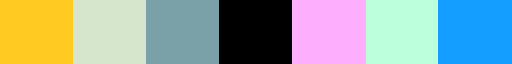

In [36]:
p.legend_dict[attributes[0]]['cmap']

## Display one object (attribute = 'lithology')

In [37]:
bh = 1
at = 1
p.boreholes_3d[bh].components

{0: [Component({'lithology': 'sable'}),
  Component({'arsenic': 'vs'}),
  Component({'cadmium': 'vi'})],
 1: [Component({'lithology': 'argile'}),
  Component({'arsenic': 'vi'}),
  Component({'cadmium': 'vs'})],
 2: [Component({'lithology': 'marne'}),
  Component({'arsenic': 'vr'}),
  Component({'cadmium': 'inconnu'})],
 3: [Component({'lithology': 'charbon'}),
  Component({'arsenic': 'vs'}),
  Component({'cadmium': 'inconnu'})],
 4: [Component({'lithology': 'dolomie'}),
  Component({'arsenic': 'inconnu'}),
  Component({'cadmium': 'vr'})]}

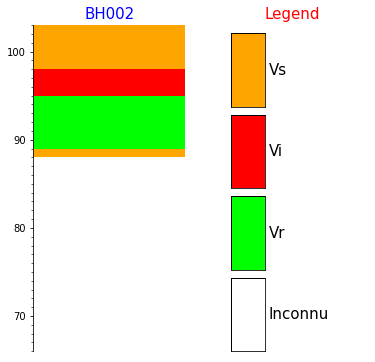

In [38]:
p.boreholes_3d[bh].log_plot(repr_attribute=attributes[at])

In [39]:
sargs = dict(title='test', title_font_size=30, label_font_size=12, n_labels=0,
             fmt="%.2f", font_family="arial", color='k',interactive=True, 
             vertical=True, italic=True, shadow=False,)

In [40]:
bh=1
at=1
p.boreholes_3d[bh].plot3d(repr_attribute=attributes[at], custom_legend=False, scalar_bar_args=sargs)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [41]:
p.plot2d()

In [42]:
p.boreholes_3d[0].intervals

[Interval({'top': Position({'middle': 101.0, 'x': 152600.0, 'y': 121039.0, 'units': 'm'}), 'base': Position({'middle': 97.0, 'x': 152600.0, 'y': 121039.0, 'units': 'm'}), 'description': '{"lithology": "sable"}, {"arsenic": "inconnu"}, {"cadmium": "inconnu"}', 'data': {}, 'components': [Component({'lithology': 'sable'}), Component({'arsenic': 'inconnu'}), Component({'cadmium': 'inconnu'})]}),
 Interval({'top': Position({'middle': 97.0, 'x': 152600.0, 'y': 121039.0, 'units': 'm'}), 'base': Position({'middle': 93.0, 'x': 152600.0, 'y': 121039.0, 'units': 'm'}), 'description': '{"lithology": "argile"}, {"arsenic": "inconnu"}, {"cadmium": "vs"}', 'data': {}, 'components': [Component({'lithology': 'argile'}), Component({'arsenic': 'inconnu'}), Component({'cadmium': 'vs'})]}),
 Interval({'top': Position({'middle': 93.0, 'x': 152600.0, 'y': 121039.0, 'units': 'm'}), 'base': Position({'middle': 81.0, 'x': 152600.0, 'y': 121039.0, 'units': 'm'}), 'description': '{"lithology": "marne"}, {"arsenic

## Plot with another attribute

In [43]:
p.legend_dict

{'lithology': {'legend': Legend(Decor({'_colour': '#ffcb23', 'width': 3, 'hatch': "'..'", 'component': Component({'lithology': 'sable'})})
  Decor({'_colour': '#d5e6cc', 'width': 3, 'hatch': "'---'", 'component': Component({'lithology': 'argile'})})
  Decor({'_colour': '#7ba1a8', 'width': 3, 'hatch': None, 'component': Component({'lithology': 'marne'})})
  Decor({'_colour': '#000000', 'width': 3, 'hatch': None, 'component': Component({'lithology': 'charbon'})})
  Decor({'_colour': '#fdaffe', 'width': 3, 'hatch': None, 'component': Component({'lithology': 'dolomie'})})
  Decor({'_colour': '#bbffdd', 'width': 3, 'hatch': "'--'", 'component': Component({'lithology': 'schiste'})})
  Decor({'_colour': '#149eff', 'width': 3, 'hatch': "'='", 'component': Component({'lithology': 'calcaire'})})),
  'cmap': <matplotlib.colors.ListedColormap at 0x7f710d0bbc40>,
  'values': ['sable',
   'argile',
   'marne',
   'charbon',
   'dolomie',
   'schiste',
   'calcaire']},
 'arsenic': {'legend': Legend(D

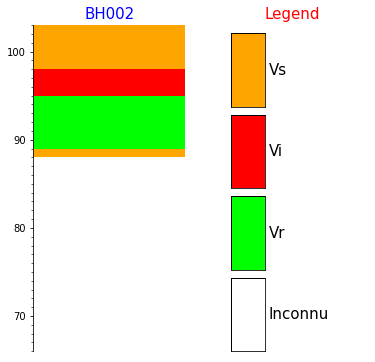

In [44]:
p.boreholes_3d[bh].log_plot(repr_attribute=attributes[1])

In [45]:
p.boreholes_3d[bh].plot3d(repr_attribute=attributes[1])

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

### Display project boreholes

In [46]:
p.plot3d(repr_attribute=attributes[0], labels_size=15, bg_color=["royalblue", "aliceblue"], window_size=(1300, 1000))

2021-07-19 21:07:28.492 (   3.287s) [        4EED8740]vtkDataSetAttributes.cx:1296  WARN| vtkPointData (0x685cb40): Can not set attribute Scalars. Only vtkDataArray subclasses can be set as active attributes.


### Boreholes in 3D using X3D for interaction within the notebook